In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import patsy
from patsy import dmatrices
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold
from sqlalchemy import create_engine

In [3]:
from wine_func import*

In [4]:
cnx = create_engine('postgresql://ubuntu@3.23.20.4:5432/wine_quality')

In [5]:
pd.read_sql_query('''SELECT * FROM wine_quality_data LIMIT 5''', cnx)

,wineid,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
df = pd.read_sql_query('''SELECT * FROM wine_quality_data''', cnx)

In [7]:
df.head(20)

,wineid,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,0,white,7.0,0.27,0.36,20.70,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,1,white,6.3,0.30,0.34,1.60,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,2,white,8.1,0.28,0.40,6.90,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,3,white,7.2,0.23,0.32,8.50,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,4,white,7.2,0.23,0.32,8.50,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,5,white,8.1,0.28,0.40,6.90,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,6,white,6.2,0.32,0.16,7.00,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,7,white,7.0,0.27,0.36,20.70,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,8,white,6.3,0.30,0.34,1.60,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,9,white,8.1,0.22,0.43,1.50,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


In [8]:
df.columns

Index(['wineid', 'type', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

In [9]:
df['sul_diox_ratio'] = df['total_sulfur_dioxide']/df['free_sulfur_dioxide']

In [10]:
df['good_wine'] = 1
df['good_wine'][(df['quality'] < 7)] = 0

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
drop_columns(['wineid', 'type', 'citric_acid',
        'free_sulfur_dioxide','total_sulfur_dioxide', 'density', 'ph','quality'],df)

In [12]:
df.to_pickle('vinho_wine_data.pickle')

In [13]:
df.head(30)

,fixed_acidity,volatile_acidity,residual_sugar,chlorides,sulphates,alcohol,sul_diox_ratio,good_wine
0,7.0,0.27,20.70,0.045,0.45,8.8,3.777778,0
1,6.3,0.30,1.60,0.049,0.49,9.5,9.428571,0
2,8.1,0.28,6.90,0.050,0.44,10.1,3.233333,0
3,7.2,0.23,8.50,0.058,0.40,9.9,3.957447,0
4,7.2,0.23,8.50,0.058,0.40,9.9,3.957447,0
5,8.1,0.28,6.90,0.050,0.44,10.1,3.233333,0
6,6.2,0.32,7.00,0.045,0.47,9.6,4.533333,0
7,7.0,0.27,20.70,0.045,0.45,8.8,3.777778,0
8,6.3,0.30,1.60,0.049,0.49,9.5,9.428571,0
9,8.1,0.22,1.50,0.044,0.45,11.0,4.607143,0


In [14]:
df.columns

Index(['fixed_acidity', 'volatile_acidity', 'residual_sugar', 'chlorides',
       'sulphates', 'alcohol', 'sul_diox_ratio', 'good_wine'],
      dtype='object')

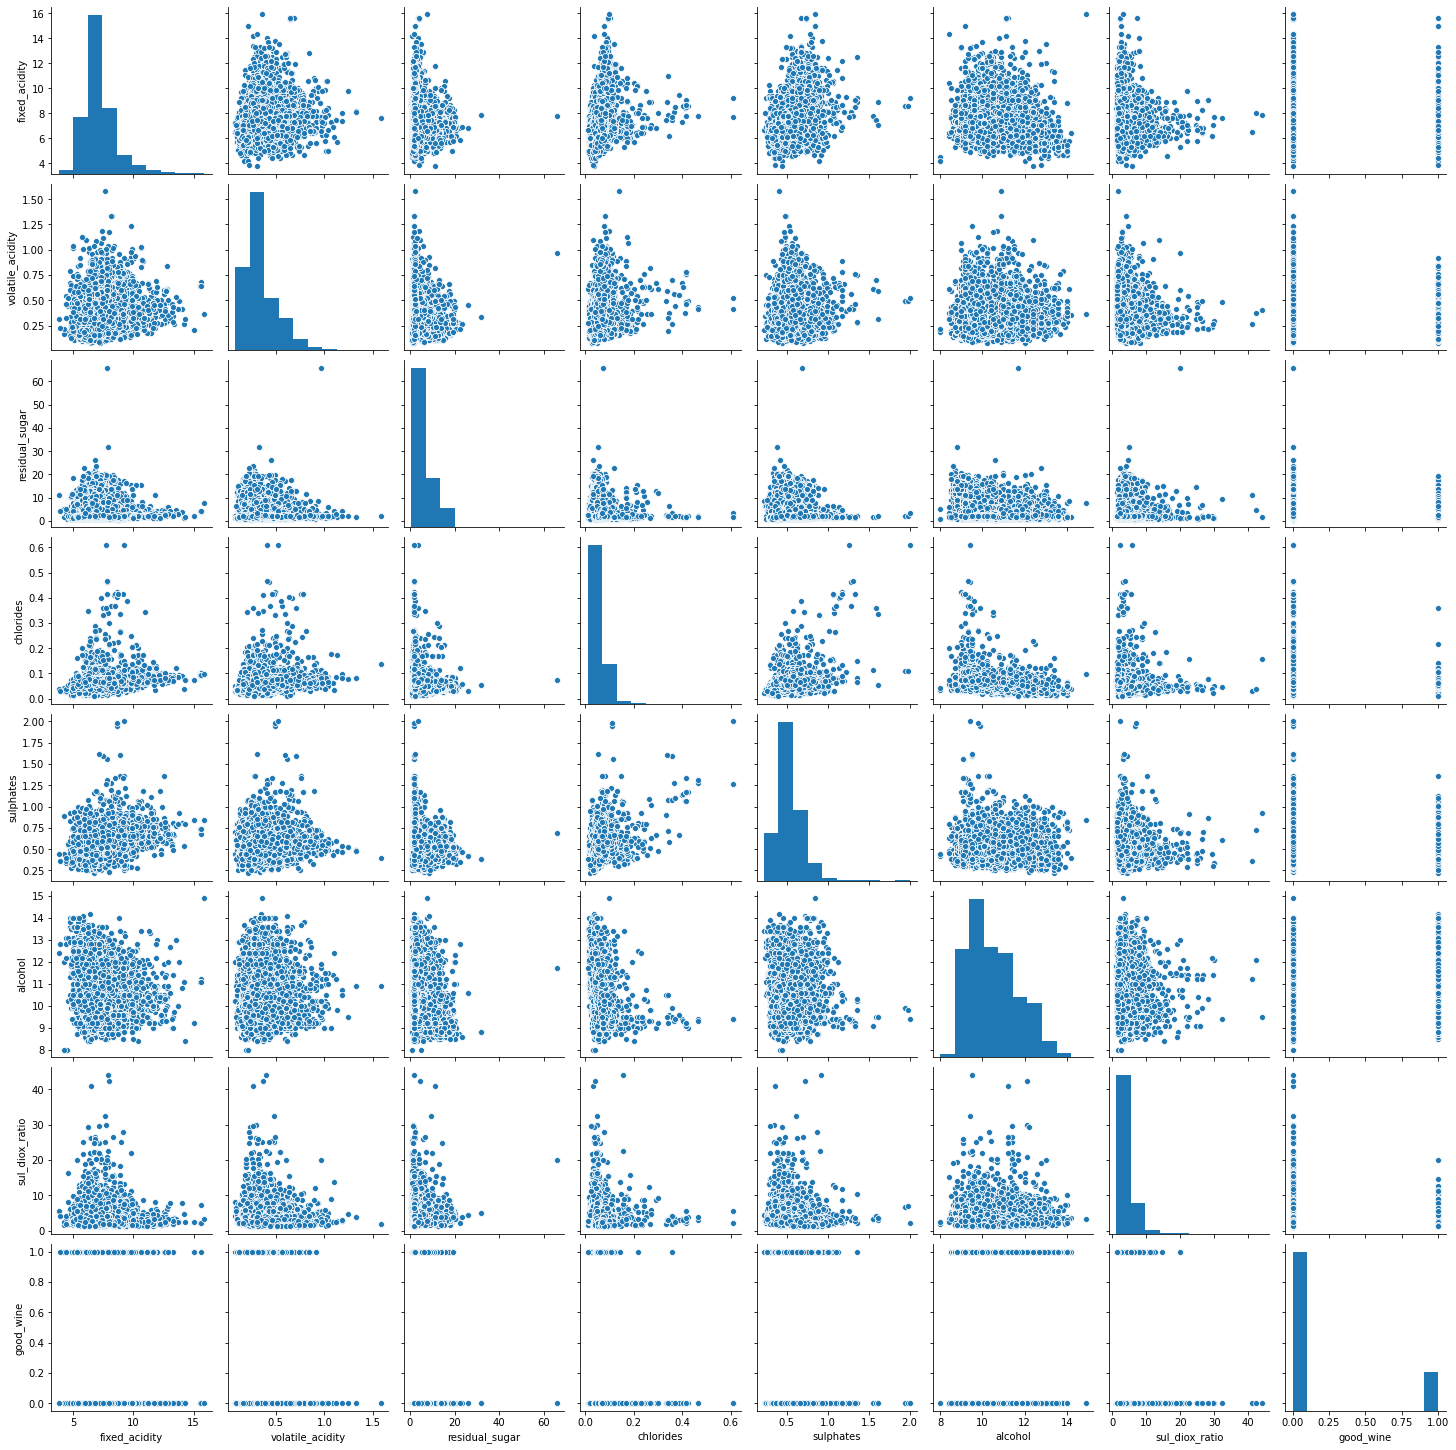

In [15]:
sns.pairplot(df)

Text(0.5, 1.0, 'Wine Quality Heat Map')

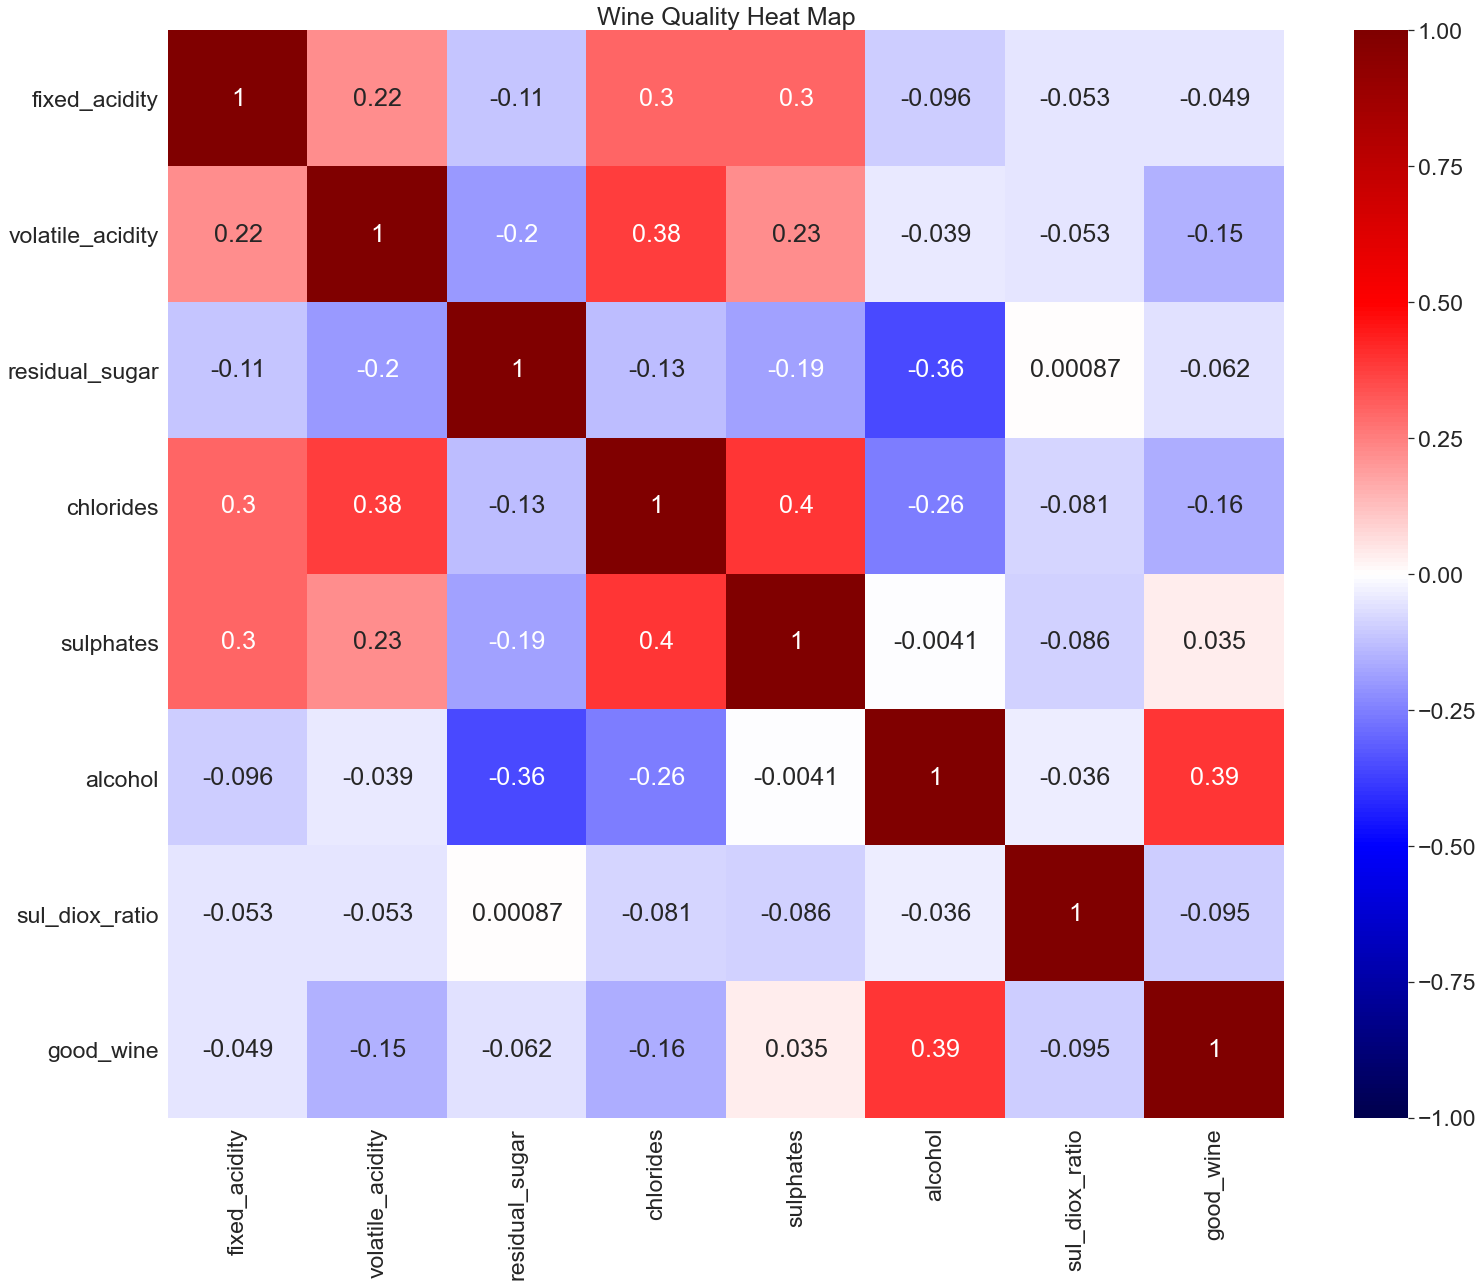

In [16]:
plt.figure(figsize=(25,20))
sns.set(font_scale = 2.1)
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.title('Wine Quality Heat Map')
# plt.savefig('wine_qual.png');